## Example. Estimating the risk of tumor in a group of rats

In [30]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pymc3 as pm
import seaborn as sns
import theano.tensor as tt
import arviz as az

plt.style.use('seaborn-darkgrid')
plt.rc('font', size=12)

%config Inline.figure_formats = ['retina']

In [2]:
rat_tumor = np.loadtxt('data/rat_tumor_data.txt', skiprows=3)

In [3]:
# If you can use bash
!cat data/rat_tumor_data.txt | head

# Rat tumor data from Tarone (1982).  Data from Table 5.1 of Bayesian Data Analysis.

y N  
0 20 
0 20 
0 20 
0 20 
0 20 
0 20 
0 20 


As you can see, the first column of `rat_tumor` is $y$ and the second column is $N$.

In [4]:
print('The shape of rat_tumor is {}'.format(rat_tumor.shape))

The shape of rat_tumor is (71, 2)


We construct the model.

In [5]:
with pm.Model() as model_1:
    
    alpha = pm.Uniform('alpha', lower=0, upper=10)
    beta = pm.Uniform('beta', lower=0, upper=25)
        
    theta = pm.Beta('theta', alpha, beta, shape=rat_tumor.shape[0])
    
    y = pm.Binomial('y', n=rat_tumor[:, 1], p=theta, observed=rat_tumor[:, 0])

In [6]:
model_1.check_test_point()

alpha_interval__     -1.39
beta_interval__      -1.39
theta_logodds__     -21.37
y                  -256.01
Name: Log-probability of test_point, dtype: float64

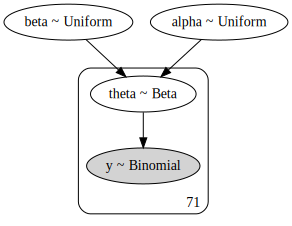

In [59]:
display(pm.model_to_graphviz(model_1))

In [8]:
with model_1:
    trace_1 = pm.sample(draws=5_000, tune=10_000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, beta, alpha]


Sampling 4 chains for 10_000 tune and 5_000 draw iterations (40_000 + 20_000 draws total) took 39 seconds.
There were 112 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5538263005662338, but should be close to 0.8. Try to increase the number of tuning steps.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7088383687262566, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


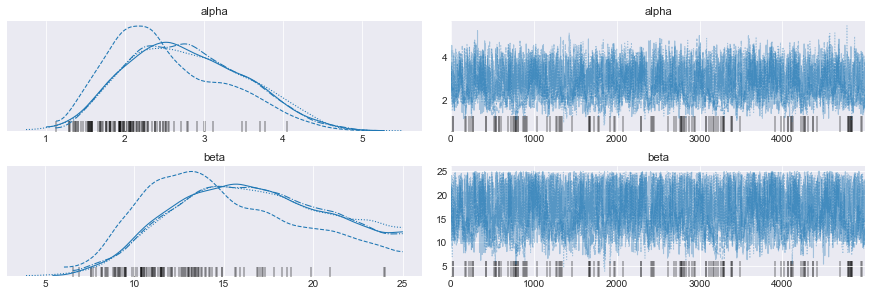

In [9]:
pm.traceplot(trace_1, var_names=['alpha', 'beta']);

In [10]:
pm.summary(trace_1, var_names=['alpha', 'beta'])

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,2.725,0.740,1.473,4.110,0.032,0.022,550.0,550.0,505.0,627.0,1.01
beta,16.298,4.313,9.764,24.832,0.196,0.139,484.0,484.0,461.0,513.0,1.02


The posterior plot of `alpha` and `beta`.

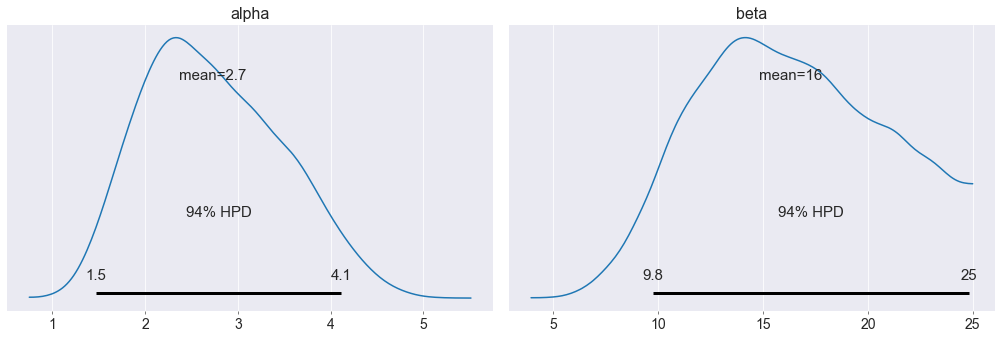

In [11]:
pm.plot_posterior(trace_1, var_names=['alpha', 'beta']);

As you can see, I have used a uniform distribution for `alpha` and `beta`. You *could* say that it is a regular prior, not good, not bad, but at the end disappointing. So let's try to improve the priors. 

The following is taken from [here][1]. According to the book, the prior for $\alpha$ and $\beta$ is 

$$p(\alpha, \beta) \propto (\alpha + \beta) ^{-5/2}$$

In order to use this prior, you have to define the logarithm of $p(\alpha, \beta)$ and use it in `pm.Potential`, [look here][2]. 

[1]:https://github.com/pymc-devs/pymc3/blob/master/docs/source/notebooks/GLM-hierarchical-binominal-model.ipynb
[2]:https://discourse.pymc.io/t/difference-between-densitydist-and-potential/307/4

In [12]:
def logp_ab(value):
    """
    Prior density for this problem
    """
    return tt.log(tt.pow(tt.sum(value), -5/2))

with pm.Model() as model_10:
    # Wealy informative prior for alpha and beta
    ab = pm.HalfFlat('ab', shape=2, testval=np.asarray([1., 1.]))
    pm.Potential('p(a, b)', logp_ab(ab))
    
    # Our alpha and beta
    alpha = pm.Deterministic('alpha', ab[0])
    beta = pm.Deterministic('beta', ab[1])
    
    theta = pm.Beta('theta', alpha=ab[0], beta=ab[1], shape=rat_tumor.shape[0])

    p = pm.Binomial('y', p=theta, observed=rat_tumor[:,0], n=rat_tumor[:,1])

In [13]:
with model_10:
    trace_10 = pm.sample(draws=5_000, tune=5_000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, ab]


Sampling 4 chains for 5_000 tune and 5_000 draw iterations (20_000 + 20_000 draws total) took 25 seconds.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
There were 75 divergences after tuning. Increase `target_accept` or reparameterize.
There were 547 divergences after tuning. Increase `target_accept` or reparameterize.
There were 944 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.692686739025813, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


Unlike in the model with the uninformative, flat prior, this model gets many divergences.

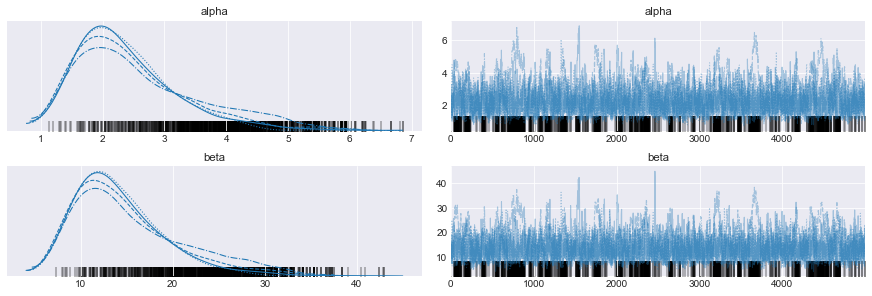

In [14]:
pm.traceplot(trace_10, var_names=['alpha', 'beta']);

In [15]:
pm.summary(trace_10, var_names=['alpha', 'beta'])

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,2.457,0.907,1.096,4.270,0.043,0.034,442.0,353.0,686.0,436.0,1.01
beta,14.674,5.510,6.347,25.677,0.256,0.201,462.0,376.0,733.0,416.0,1.01


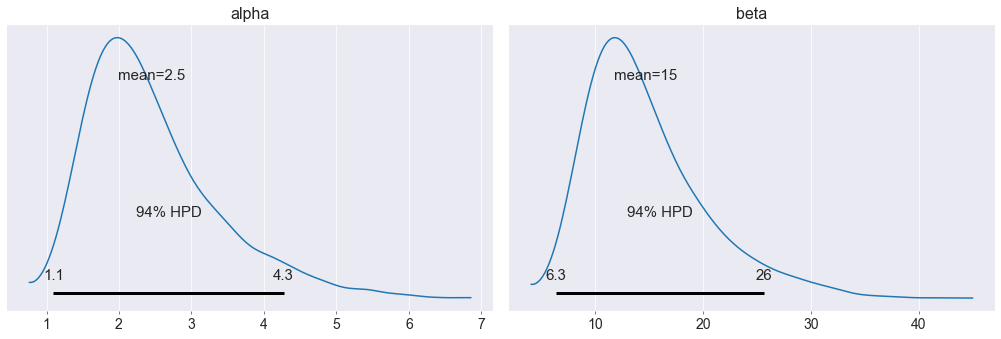

In [16]:
pm.plot_posterior(trace_10, var_names=['alpha', 'beta']);

Better, don't you think? And they are closer to the value $(\alpha, \beta) = (2.4, 14.0)$ shown in the book.

The next plots are a contour plot and a scatter plot.

In [17]:
# Why do we plot only a subset of the α's and β's?

begi = 4_000

alpha_trunc = trace_10['alpha'][begi: begi + 1000] # in the original, alpha and beta were flipped.
beta_trunc = trace_10['beta'][begi: begi + 1000]

idata_10 = az.from_pymc3(trace_10, coords={'ab_index': ['alpha', 'beta'], 'experiments': range(71)}, dims={'ab': ['ab_index'], 'theta': ['experiments']})

In [18]:
idata_10.posterior['log(alpha / beta)'] = np.log(idata_10.posterior['alpha'] / idata_10.posterior['beta'])
idata_10.posterior['log(alpha + beta)'] = np.log(idata_10.posterior['alpha'] + idata_10.posterior['beta'])

In [19]:
idata_10.posterior

<xarray.Dataset>
Dimensions:            (ab_index: 2, chain: 4, draw: 5000, experiments: 71)
Coordinates:
  * chain              (chain) int64 0 1 2 3
  * draw               (draw) int64 0 1 2 3 4 5 ... 4995 4996 4997 4998 4999
  * ab_index           (ab_index) <U5 'alpha' 'beta'
  * experiments        (experiments) int64 0 1 2 3 4 5 6 ... 65 66 67 68 69 70
Data variables:
    ab                 (chain, draw, ab_index) float64 2.116 15.41 ... 13.75
    alpha              (chain, draw) float64 2.116 1.931 1.633 ... 1.648 2.129
    beta               (chain, draw) float64 15.41 10.82 9.779 ... 12.1 13.75
    theta              (chain, draw, experiments) float64 0.05616 ... 0.1647
    log(alpha / beta)  (chain, draw) float64 -1.985 -1.723 ... -1.994 -1.866
    log(alpha + beta)  (chain, draw) float64 2.864 2.545 2.435 ... 2.621 2.765
Attributes:
    created_at:                 2020-04-20T00:48:55.380642
    arviz_version:              0.7.0
    inference_library:          pymc3
    inference_library_version:  3.8

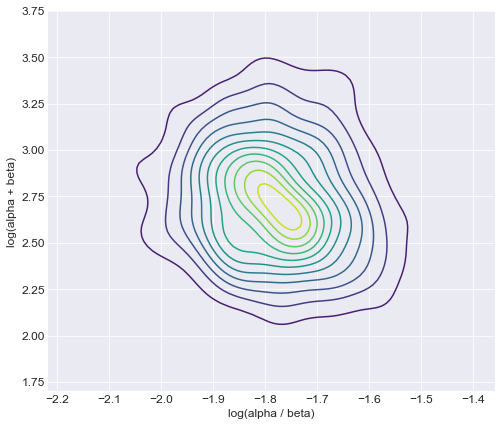

In [20]:
fig, ax = plt.subplots(figsize=(8, 7))
sns.kdeplot(np.log(alpha_trunc /  beta_trunc), np.log(alpha_trunc + beta_trunc),
            cmap=plt.cm.viridis, n_levels=11, ax=ax)
# ax.set_xlim(1.5, 2.1)
ax.set_ylim(1.7, 3.75)
ax.set_xlabel('log(alpha / beta)')
ax.set_ylabel('log(alpha + beta)');

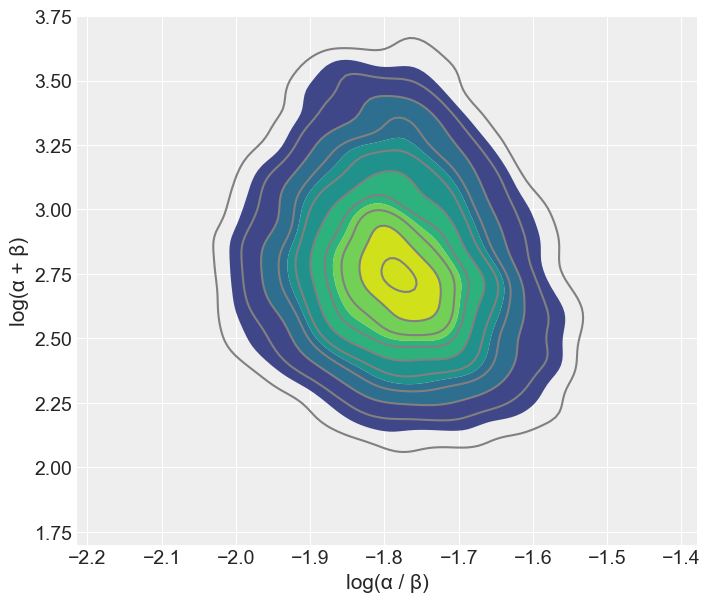

In [47]:
az.style.use("arviz-darkgrid")
mpl.rcParams["image.cmap"] = 'viridis'
fig, ax = plt.subplots(figsize=(8, 7))

az.plot_kde(values2=idata_10.posterior['log(alpha + beta)'], values=idata_10.posterior['log(alpha / beta)'], ax=ax,
            # backend_kwargs={'cmap':'viridis'}, -- this argument is ignored.
                contour=True, fill_last=False,
                contour_kwargs={'levels': 10,}) # Setting different levels here does not have any effect.
    
# ax.set_xlim(1.5, 2.1)
ax.grid()
ax.set_ylim(1.7, 3.75)
ax.set_xlabel('log(α / β)')
_ = ax.set_ylabel('log(α + β)')


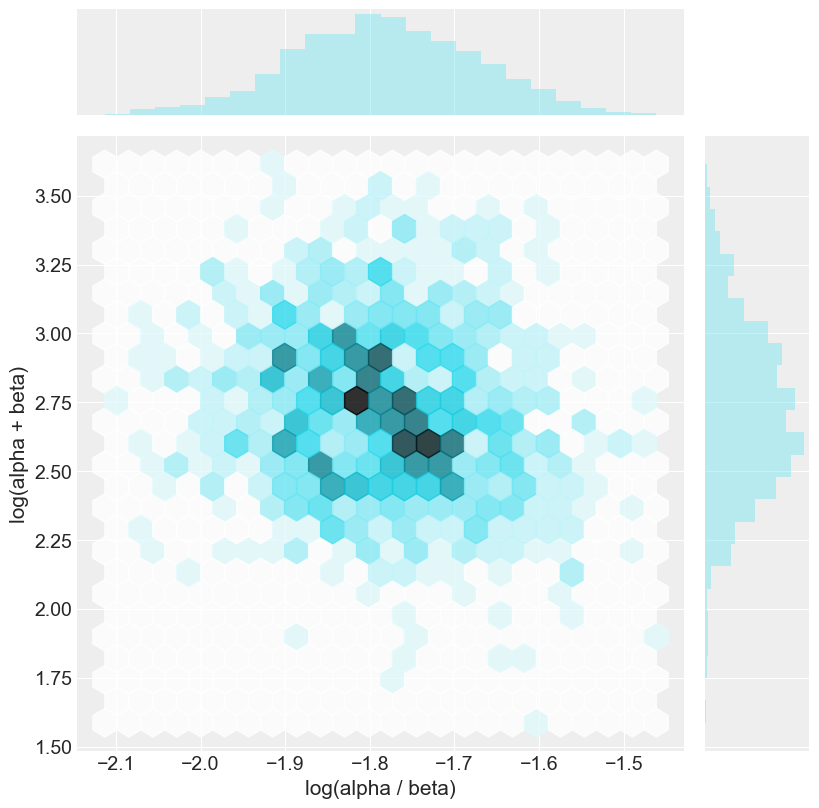

In [43]:
g = sns.jointplot(np.log(alpha_trunc /  beta_trunc), np.log(alpha_trunc + beta_trunc),
             alpha=0.8, color='C5', kind='hex', height=8)
g.set_axis_labels('log(alpha / beta)', 'log(alpha + beta)');

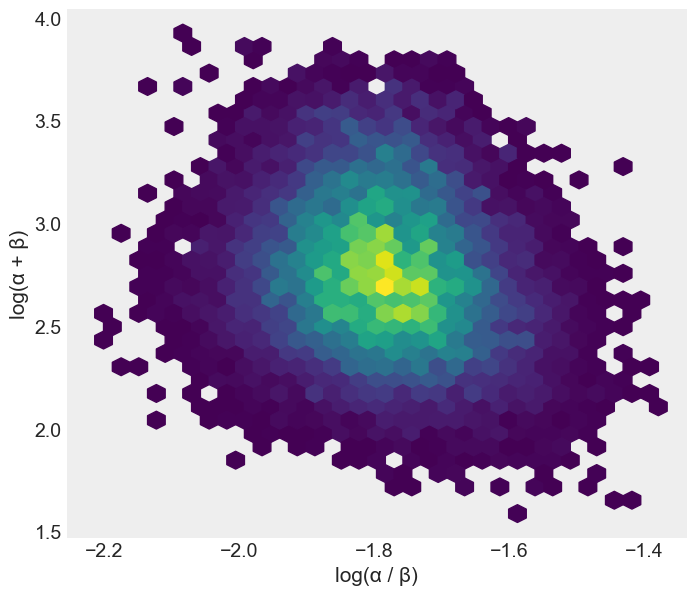

In [54]:
az.style.use("arviz-darkgrid")
fig, ax = plt.subplots(figsize=(8, 7))
mpl.rcParams["image.cmap"] = 'viridis'

az.plot_pair(idata_10, var_names=['log(alpha / beta)', 'log(alpha + beta)'], colorbar=True, kind=['hexbin'], ax=ax)
ax.set_xlabel('log(α / β)') 
ax.set_ylabel('log(α + β)');

Now, we draw 1000 samples for `theta` from the posterior distribution.

In [24]:
post_theta = pm.fast_sample_posterior_predictive(trace_10, model=model_10, var_names=['theta'])

Posterior medians and 95% highest posterior density of rat tumor rates, $\theta_j$ (plotted vs. observed tumor rates $y_j / n_j$).

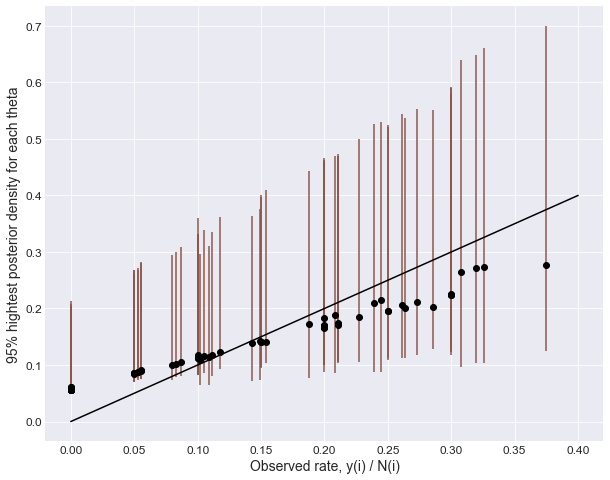

In [25]:
median_theta = []

for i in range(post_theta['theta'].shape[1]):
    median_theta.append(np.median(post_theta['theta'][:, i]))

error_up = []
error_down = []

for i in range(post_theta['theta'].shape[1]):
    a, b = pm.hpd(post_theta['theta'][:, i], alpha=0.05)
    error_up.append(b)
    error_down.append(a)
    
plt.figure(figsize=(10,8))
plt.errorbar(rat_tumor[:, 0] / rat_tumor[:, 1], median_theta, fmt='o',
            yerr=[error_down, error_up], ecolor='C5', markerfacecolor='k', mec='k',
            errorevery=1)
plt.plot(np.linspace(0, .4, 10), np.linspace(0, .4, 10),
        color='k')
plt.xlabel('Observed rate, y(i) / N(i)', fontsize=14)
plt.ylabel('95% hightest posterior density for each theta', fontsize=14);

## Example: parallel experiments in eight schools

Data of the eight schools model.

In [56]:
yy = np.array([28.,  8., -3.,  7., -1.,  1., 18., 12.])
sigma = np.array([15., 10., 16., 11.,  9., 11., 10., 18.])

In [57]:
with pm.Model() as model_2:
    mu = pm.Uniform('mu', lower=0, upper=30)
    tau = pm.Uniform('tau', lower=0, upper=30)
    theta = pm.Normal('theta', mu=mu, sd=tau, shape=yy.shape[0])
    obs = pm.Normal('obs', mu=theta, sd=sigma, observed=yy)

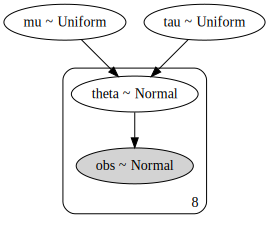

In [58]:
display(pm.model_to_graphviz(model_2))

In [163]:
with model_2:
    trace_2 = pm.sample(draws=15_000, tune=30_000, nuts_kwargs={'target_accept':0.99})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, tau, mu]
Sampling 4 chains: 100%|██████████| 180000/180000 [16:11<00:00, 185.24draws/s]
There were 99 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9589009742029759, but should be close to 0.99. Try to increase the number of tuning steps.
There were 129 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 45 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


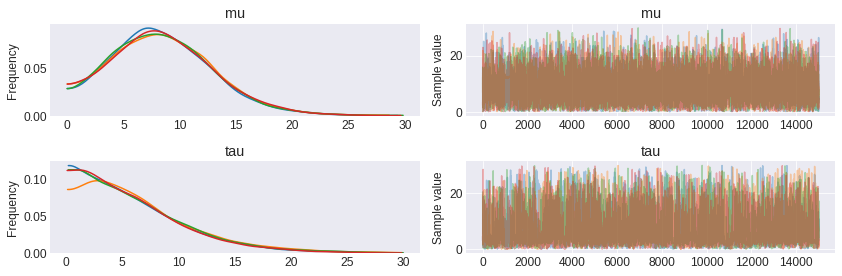

In [164]:
pm.traceplot(trace_2, varnames=['mu', 'tau']);

In [165]:
pm.summary(trace_2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
theta__0,11.683407,8.072628,0.079508,-2.364170,29.202658,9540.086988,1.000255
theta__1,8.241418,6.072992,0.042111,-3.844689,20.508132,18621.837948,1.000002
theta__2,6.644003,7.352964,0.058526,-9.293521,20.750359,18105.525260,1.000052
theta__3,8.034519,6.311785,0.043290,-4.543239,20.898769,18477.560143,0.999985
theta__4,5.535042,6.087216,0.064419,-7.261684,16.908282,11157.549331,1.000168
theta__5,6.588537,6.431270,0.052744,-7.068402,18.973000,16525.202110,1.000116
theta__6,10.932158,6.576583,0.060985,-0.679374,25.058582,10407.796898,1.000057
theta__7,8.862579,7.519571,0.048141,-5.562598,25.369402,19120.224809,1.000053
mu,8.534240,4.530875,0.041987,0.000951,16.493687,9770.491536,1.000061
tau,6.315065,4.984469,0.092827,0.151026,16.171447,3002.260439,1.001085


The posterior plot of `tau`

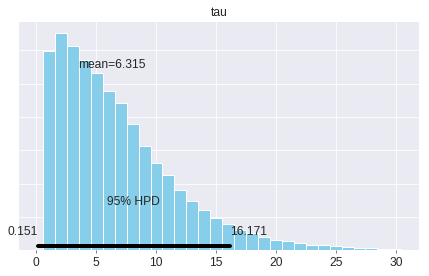

In [166]:
pm.plot_posterior(trace_2, varnames=['tau']);

We draw 1000 samples of `tau` and `theta` from the posterior distribution.

In [167]:
with model_2:
    post_trace_sample = pm.sample_ppc(trace_2, samples=1_000, vars=[tau, theta])

100%|██████████| 1000/1000 [00:00<00:00, 12923.44it/s]


In [168]:
def partition_mean(ll, part):
    """
    It takes two arguments, a list of pairs of points, (x, y), and the 
    length of the partition. It returns two lists, the first is a 
    list of means for each partiton on x and the second is a list of means
    for each partition on y.
    
    Returns:
        mean_x::list
            mean of each partition on x
        mean_obs::list
            mean of each partition on y
    """
    mean_x = []
    mean_obs = []

    for i in range(0, len(ll), part):
        ll_temp = ll[i: i + part]
        x_temp = []
        y_temp = []
        for j in range(len(ll_temp)):
            x_temp.append(ll_temp[j][0])
            y_temp.append(ll_temp[j][1])
        mean_x.append(np.mean(x_temp))
        mean_obs.append(np.mean(y_temp))
        
    return mean_x, mean_obs

def partition_std(ll, part):
    """
    It takes two arguments, a list of pairs of points, (x, y), and the 
    length of the partition. It returns two lists, the first is a 
    list of means for each partiton on x and the second is a list of 
    standard deviation for each partition on y.
    
    Returns:
        mean_x::list
            mean of each partition on x
        mean_obs::list
            standard deviation of each partition on y
    """
    mean_x = []
    mean_obs = []

    for i in range(0, len(ll), part):
        ll_temp = ll[i: i + part]
        x_temp = []
        y_temp = []
        for j in range(len(ll_temp)):
            x_temp.append(ll_temp[j][0])
            y_temp.append(ll_temp[j][1])
        mean_x.append(np.mean(x_temp))
        mean_obs.append(np.std(y_temp, ddof=1))
        
    return mean_x, mean_obs

This plot is for the conditional posterior means of treatment effects, $E(\theta_j \mid \tau, y)$, as functions of the between-school standard deviation $\tau$, for the educational testing example.

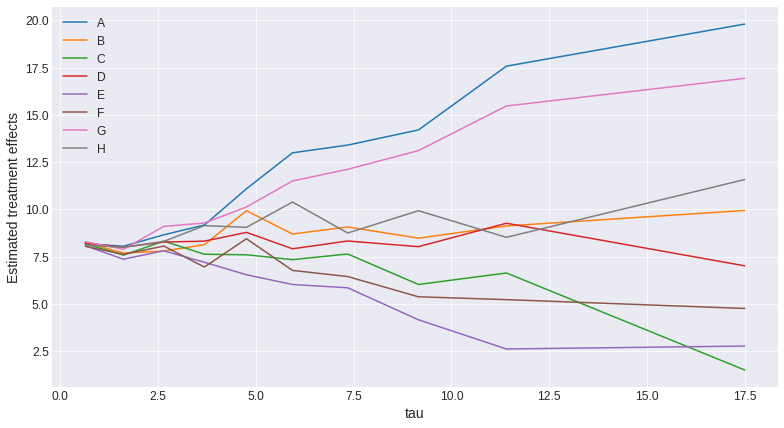

In [169]:
plt.figure(figsize=(13, 7))

for i, z in zip(range(post_trace_sample['theta'].shape[1]), 
                ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']):
    tau_post = post_trace_sample['tau']
    obs_post = post_trace_sample['theta'][:, i]

    # It is necessary to sort the list of pairs of points
    ll = sorted(list(zip(tau_post, obs_post)))
    x, y = partition_mean(ll, 100)
    plt.plot(x, y, label=z)

plt.xlabel('tau', fontsize=14)
plt.ylabel('Estimated treatment effects', fontsize=14)
plt.legend();

This plot is for the conditional posterior standard deviations of treatment effects, $\textrm{sd}\,(\theta_j \mid \tau, y)$, as functions of the between-school standard deviation $\tau$, for the educational testing example.

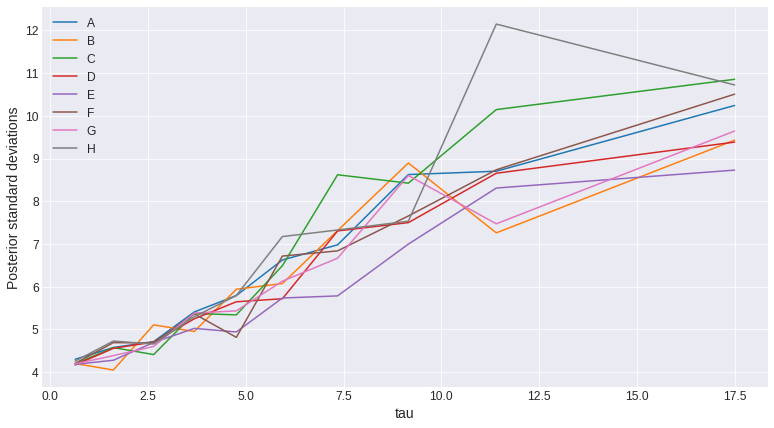

In [170]:
plt.figure(figsize=(13, 7))

for i, z in zip(range(post_trace_sample['theta'].shape[1]), 
                ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']):
    tau_post = post_trace_sample['tau']
    obs_post = post_trace_sample['theta'][:, i]

    # It is necessary to sort the list of pairs of points
    ll = sorted(list(zip(tau_post, obs_post)))
    x, y = partition_std(ll, 100)
    plt.plot(x, y, label=z)

plt.xlabel('tau', fontsize=14)
plt.ylabel('Posterior standard deviations', fontsize=14)
plt.legend();

We draw 200 samples of `obs`.

In [177]:
with model_2:
    post_obs = pm.sample_ppc(trace_2, samples=200, vars=[obs])

100%|██████████| 200/200 [00:00<00:00, 3248.50it/s]


Reproducing the Table 5.3

In [178]:
print('{:^1} {:^50}'.format('School', 'Posterior quantiles'))
print('{:^7} {:^10} {:^10} {:^10} {:^10} {:^10}'.format(' ', '2.5%', '25%', 'median', '75%', '97.5%'))
print('-' * 70)

for i, z in zip(range(post_obs['obs'].shape[1]),
                ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']):
    
    a1 = np.percentile(post_obs['obs'][:, i], 2.5)
    a2 = np.percentile(post_obs['obs'][:, i], 25)
    a3 = np.percentile(post_obs['obs'][:, i], 50)
    a4 = np.percentile(post_obs['obs'][:, i], 75)
    a5 = np.percentile(post_obs['obs'][:, i], 97.5)
    print('{:^7} {:^10.0f} {:^10.0f} {:^10.0f} {:^10.0f} {:^10.0f}'.format(z, a1, a2, a3, a4, a5))

School                Posterior quantiles                
           2.5%       25%       median      75%       97.5%   
----------------------------------------------------------------------
   A       -18         -1         8          18         43    
   B       -15         2          8          15         29    
   C       -33         -4         6          19         43    
   D       -18         -1         6          15         31    
   E       -15         -1         5          12         23    
   F       -21         -4         6          14         30    
   G       -11         2          9          18         37    
   H       -23         -3         8          19         42    


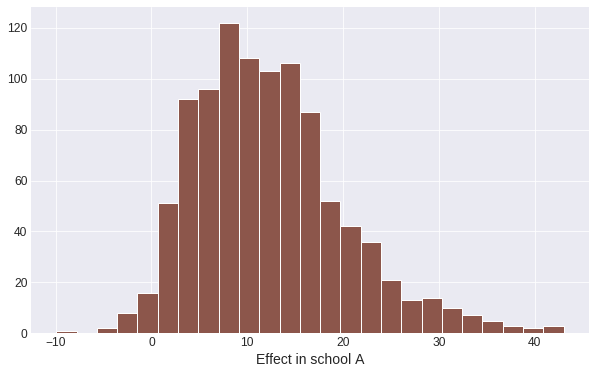

In [179]:
plt.figure(figsize=(10, 6))
_, _, _ = plt.hist(post_trace_sample['theta'][:, 0], color='C5', bins=25, edgecolor='w')
plt.xlabel('Effect in school A', fontsize=14);

In [180]:
max_theta = []

for i in range(200):
    with model_2:
        post_theta = pm.sample_ppc(trace_2, samples=200, vars=[theta], progressbar=False)
        max_theta.append(np.max(post_theta['theta'][:, :]))

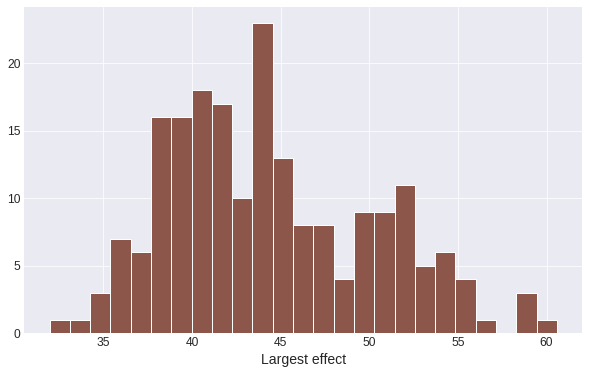

In [181]:
plt.figure(figsize=(10, 6))
_, _, _ = plt.hist(max_theta, color='C5', bins=25, edgecolor='w')
plt.xlabel('Largest effect', fontsize=14);

In [287]:
np.mean(np.array(max_theta) >= 28.4)

1.0

Ok, so the results are not quite good, I mean, there are a lot of discrepancies and the differences are notorious when you compare the two histograms previously showed with the Figure 5.8 (even more if you compare it with Table 5.3). Yes, the question is: Why does this happen? Is the algorithm behind `pymc3` the reason of all this? I would say that priors are really bad and the geometry behind the model is nasty. More info here: https://docs.pymc.io/notebooks/Diagnosing_biased_Inference_with_Divergences.html

Changing the prior of `tau_sq` to `inv-gamma(1, 1)`.

In [222]:
with pm.Model() as model_3:
    mu = pm.Uniform('mu', lower=0, upper=30)
    tau_sq = pm.InverseGamma('tau_sq', 1, 1)
    theta = pm.Normal('theta', mu=mu, sd=tau_sq, shape=yy.shape[0])
    obs = pm.Normal('obs', mu=theta, sd=sigma, observed=yy)

In [223]:
model_3.check_test_point()

mu_interval__    -1.39
tau_sq_log__     -1.31
theta            -1.81
obs             -31.29
Name: Log-probability of test_point, dtype: float64

In [227]:
with model_3:
    trace_3 = pm.sample(draws=5_000, tune=15_000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, tau_sq, mu]
Sampling 4 chains: 100%|██████████| 80000/80000 [01:36<00:00, 828.29draws/s] 
There were 342 divergences after tuning. Increase `target_accept` or reparameterize.
There were 632 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6556958887998723, but should be close to 0.8. Try to increase the number of tuning steps.
There were 304 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7055707909541307, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1070 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5612203902993772, but should be close to 0.8. Try to increase the numb

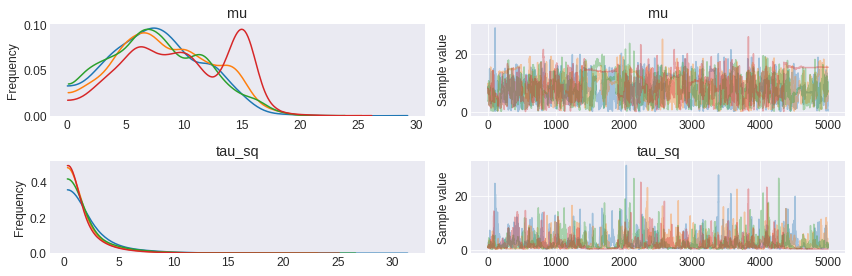

In [228]:
pm.traceplot(trace_3, varnames=['mu', 'tau_sq']);

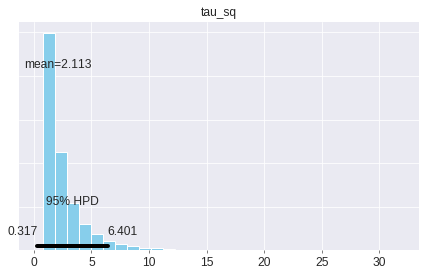

In [230]:
pm.plot_posterior(trace_3, varnames=['tau_sq']);

Although this plot is similar to the Figure 5.9, they are not the same.

Changing the prior of `tau_sq` to `inv-gamma(0.001, 0.001)`.

In [234]:
with pm.Model() as model_4:
    mu = pm.Uniform('mu', lower=0, upper=30)
    tau_sq = pm.InverseGamma('tau_sq', 0.001, 0.001)
#     tau = pm.Deterministic('tau', pm.math.sqrt(tau_sq))
    theta = pm.Normal('theta', mu=mu, sd=tau_sq, shape=yy.shape[0])
    obs = pm.Normal('obs', mu=theta, sd=sigma, observed=yy)

In [284]:
with model_4:
    trace_4 = pm.sample(draws=5_000, tune=15_000, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [theta, tau_sq, mu]
Sampling 2 chains: 100%|██████████| 40000/40000 [00:56<00:00, 704.66draws/s]
There were 90 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7026484528842684, but should be close to 0.8. Try to increase the number of tuning steps.
There were 67 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


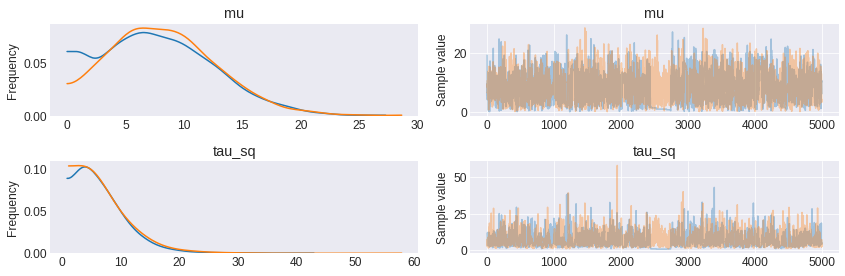

In [285]:
pm.traceplot(trace_4, varnames=['mu', 'tau_sq']);

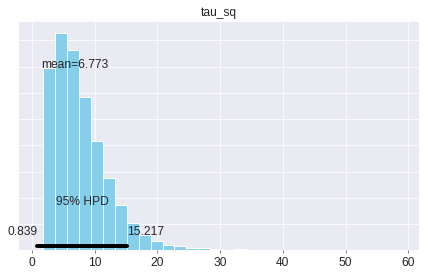

In [286]:
pm.plot_posterior(trace_4, varnames=['tau_sq']);

Again, although this plot is similar to the Figure 5.9, they are not the same.

Changing the prior of `tau_sq` to half-Cauchy. This time, the data are the first three schools.

In [256]:
with pm.Model() as model_5:
    mu = pm.Uniform('mu', lower=0, upper=30)
    tau_sq = pm.HalfCauchy('tau_sq', 25)
    theta = pm.Normal('theta', mu=mu, sd=tau_sq, shape=yy[:3].shape[0])
    obs = pm.Normal('obs', mu=theta, sd=sigma[:3], observed=yy[:3])

In [257]:
with model_5:
    trace_5 = pm.sample(draws=5000, tune=10_000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, tau_sq, mu]
Sampling 4 chains: 100%|██████████| 60000/60000 [00:42<00:00, 1420.26draws/s]
There were 315 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7102855150758897, but should be close to 0.8. Try to increase the number of tuning steps.
There were 168 divergences after tuning. Increase `target_accept` or reparameterize.
There were 151 divergences after tuning. Increase `target_accept` or reparameterize.
There were 199 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


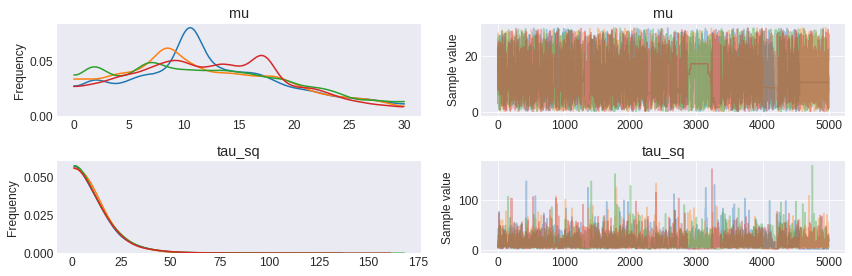

In [258]:
pm.traceplot(trace_5, varnames=['mu', 'tau_sq']);

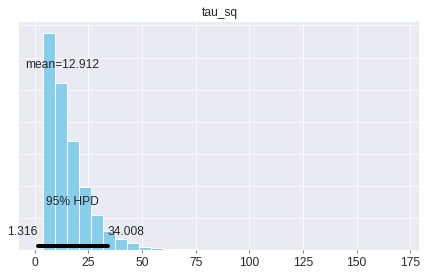

In [260]:
pm.plot_posterior(trace_5, varnames=['tau_sq']);

Changing the prior of `tau_sq`. And the data are the first three schools.

In [291]:
with pm.Model() as model_6:
    mu = pm.Uniform('mu', lower=0, upper=30)
    tau_sq = pm.Uniform('tau_sq', lower=0, upper=100_000)
    theta = pm.Normal('theta', mu=mu, sd=tau_sq, shape=yy[:3].shape[0])
    obs = pm.Normal('obs', mu=theta, sd=sigma[:3], observed=yy[:3])

In [292]:
with model_6:
    trace_6 = pm.sample(draws=7_000, tune=10_000, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [theta, tau_sq, mu]
Sampling 2 chains: 100%|██████████| 34000/34000 [00:34<00:00, 978.84draws/s] 
There were 158 divergences after tuning. Increase `target_accept` or reparameterize.
There were 263 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7156627888145205, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


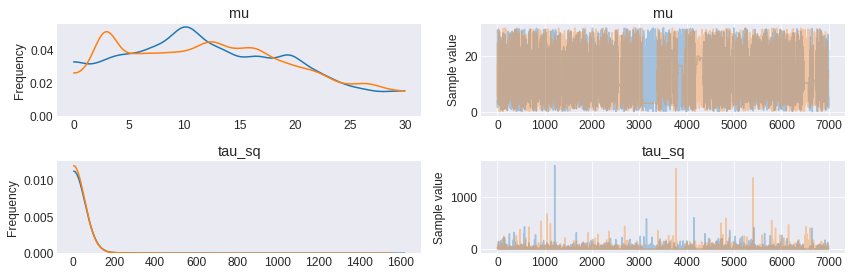

In [293]:
pm.traceplot(trace_6, varnames=['mu', 'tau_sq']);

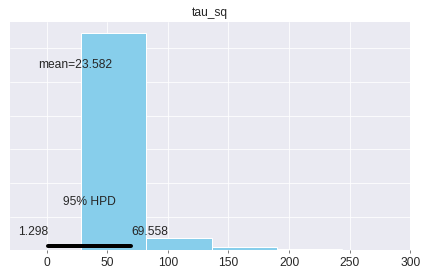

In [298]:
fig, ax = plt.subplots()
pm.plot_posterior(trace_6, varnames=['tau_sq'], ax=ax)
ax.set_xlim(-30, 300);

In [55]:
%load_ext watermark

In [57]:
%watermark -iv -v -p theano,scipy,matplotlib,arviz -m

pymc3   3.8
arviz   0.7.0
seaborn 0.10.0
numpy   1.18.1
CPython 3.6.8
IPython 7.12.0

theano 1.0.4
scipy 1.4.1
matplotlib 3.1.3
arviz 0.7.0

compiler   : GCC 4.2.1 Compatible Apple LLVM 10.0.1 (clang-1001.0.46.4)
system     : Darwin
release    : 19.4.0
machine    : x86_64
processor  : i386
CPU cores  : 16
interpreter: 64bit
